#1. 데이터 다운받기

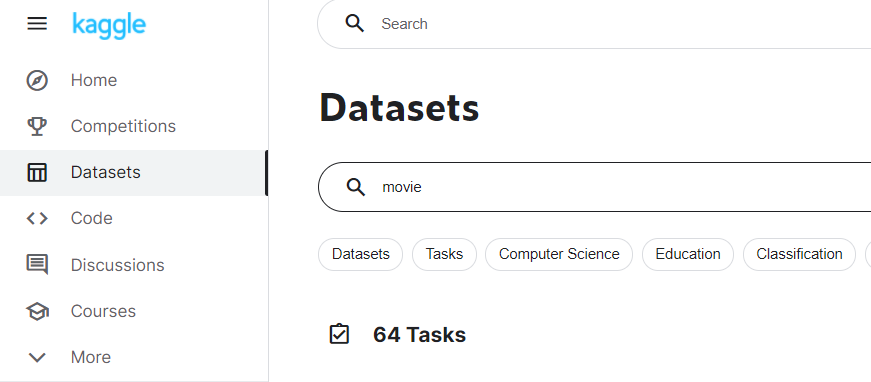

>위와 같이 kaggle 사이트에 접속한 후 왼쪽의 Datasets을 클릭한다. 오른쪽 Datasets 아래에 있는 검색창에 movie를 입력한다.

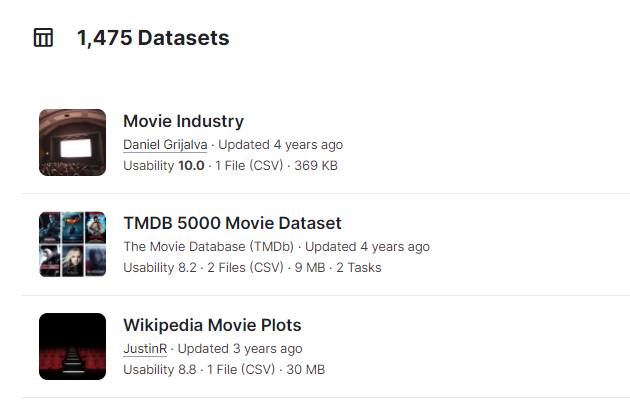

> 검색 결과 중 TMDB 5000 Movie Dataset을 클릭한다.

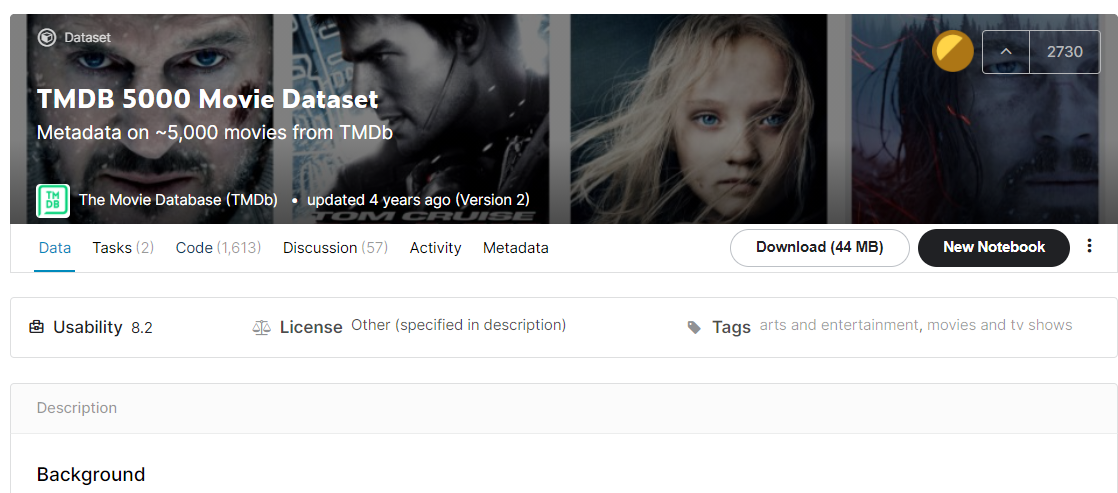

> 오른쪽 중간에 Download 부분을 클릭한다.

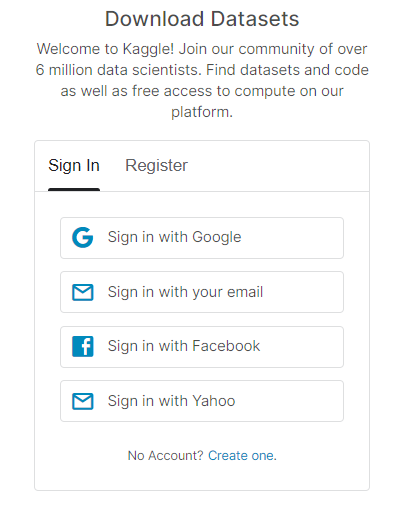

>kaggle 데이터는 로그인 후 사용 가능함으로 회원가입 후 사용하자

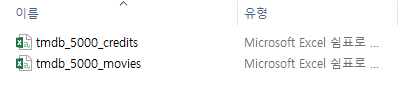

> 다운로드 완료하면 위와 같이 2개의 파일이 존재하는 것을 확인할 수 있다.

#2. 콘텐츠 기반 필터링
> 콘텐츠 기반 필터링은 콘텐츠의 속성 정보를 이용하여 유사성을 판단하는 기법이다. 예를 들어 영화 추천 서비스를 만든다고 한다면 영화가 가지고 있는 속성(장르, 감독, 배우, 평점, 키워드, 영화 설명)을 이용하여 서비스를 만들 수 있다.

##2.1 파일 읽어오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

movies = pd.read_csv('/content/drive/MyDrive/2. 추천 알고리즘/2. content Based/data/tmdb_5000_movies.csv')
movies.shape

(4803, 20)

>데이터를 정상적으로 읽어 들였다. shape은 구조를 표현하는 함수로 4803개의 행과 20개의 열(속성, feature)로 이루어져 있다. 머신러닝에서는 특징 또는 특성이라는 의미로 feature라는 단어를 많이 사용한다. 기존에 학습한 열을 feature라고 표현하며 앞으로는 이러한 속성 정보를 feature라고 표현하도록 하겠다.

##2.2 feature 줄이기

In [ ]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


>위와 같이 여러 feature 들을 확인할 수 있다. 우리는 여기서 다음과 같은 내용만 사용할 것이다.
* id : 아이디
* title : 영화 제목
* genres : 장르
* vote_average : 평점
* vote_count : 투표수
* popularity : 인기도
* keywords : 주요 키워드
* overview : 영화 개요

In [ ]:
df_movies = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4803 non-null   int64  
 1   title         4803 non-null   object 
 2   genres        4803 non-null   object 
 3   vote_average  4803 non-null   float64
 4   vote_count    4803 non-null   int64  
 5   popularity    4803 non-null   float64
 6   keywords      4803 non-null   object 
 7   overview      4800 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 300.3+ KB


In [ ]:
# 결측치 처리
df_movies_back.info()

In [ ]:
df_movies_back[df_movies_back['overview'].isnull()]

In [ ]:
# df_movies_back.dropna().info()
df_movies_back.dropna(inplace=True)
df_movies_back.info()

> 확인결과 overview에서 3개의 결측치가 발생했다. 우리가 추천할 내용은 장르를 기반으로 추천할 것이기 때문에 overview는 배제하고 진행해도 상관이 없다.


In [ ]:
df_movies[['genres', 'keywords']][:3]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name..."


In [ ]:
pd.set_option('max_colwidth', 100)
# pd.reset_option('max_colwidth')
df_movies[['genres', 'keywords']][:3]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic is..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret..."


> 장르를 기준으로 추천을 진행할 것이므로 장르 정보만 확인하면 되나 keywords도 비슷한 구조로 되어 있어 같이 확인해 보았다. 

>set_option은 pandas에서 지원하는 함수로 여러 옵션들이 있으나 max_colwidth는 한줄에 표시할 수 있는 문자열 개수를 지정할 수 있다. 입력값이 -1이면 모든 결과를 출력해 준다. 다시 원래 옵션으로 변경하려면 reset_option을 진행하면 된다.

> 장르 부분에서 id와 name정보는 쌍으로 id의 정보를 알면 추후 추천 비교시 빠르게 처리되겠지만 현재 우리에게 주어진 데이터에는 장르에 사용된 id, name의 모든 정보가 있는 것이 아니므로 name정보를 필터링 처리할 예정이다.

##2.3 데이터 가공

In [ ]:
str_dict = "{'id':12, 'name':'Action'}"
print(type(str_dict), " : ", str_dict)
print(str_dict['id'])
print(str_dict['name'])

<class 'str'>  :  {'id':12, 'name':'Action'}


TypeError: ignored

>str에 dictionary 형식으로 데이터를 입력했다. 타입과 결과를 출력해 보면 두 번째 출력 부분의 str['id']가 출력이 안되는 것을 볼 수 있다. 당연하게도 이 부분은 str 형식이기 때문이다. 

In [ ]:
from ast import literal_eval

dict = literal_eval(str_dict)
print(type(dict), " : ", dict)
print(dict['id'])
print(dict['name'])

<class 'dict'>  :  {'id': 12, 'name': 'Action'}
12
Action


>literal_eval함수를 이용하면 str 형식을 dict 형식으로 변경할 수 있으며 dict['id']의 결과가 정상적으로 출력되는 것을 볼 수 있다.

>우리가 파일에서 데이터를 읽어 들이면 dictionary 형식으로 저장하더라도 string형식으로 데이터를 얻어 오기 때문에 변환 작업이 필요하다.

In [ ]:
from ast import literal_eval

print(df_movies['genres'])
print(type(df_movies['genres'][:1]))
print(type(df_movies['genres'][:1][0]))
print(df_movies['genres'][:1][0][0])

0       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
1       [{"id": 12, "name": "Adventure"}, {"id": 14, "...
2       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
3       [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4       [{"id": 28, "name": "Action"}, {"id": 12, "nam...
                              ...                        
4798    [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4799    [{"id": 35, "name": "Comedy"}, {"id": 10749, "...
4800    [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...
4801                                                   []
4802                  [{"id": 99, "name": "Documentary"}]
Name: genres, Length: 4803, dtype: object
<class 'pandas.core.series.Series'>
<class 'str'>
[


In [ ]:
from ast import literal_eval
# literal_eval은 str 형을 원래의 형식으로 변경해줌
tmp = literal_eval(df_movies['genres'][0])
type(tmp)
tmp[0]
tmp[0]['id']

In [ ]:
#dict로 변환
df_movies['genres']=df_movies['genres'].apply(literal_eval)
print(df_movies['genres'][:1][0][0])

{'id': 28, 'name': 'Action'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


> 장르의 첫번째 데이터를 출력해 보면 모든 결과가 나타나고 0번째 데이터를 읽어 보면 [(대괄호) 하나만 나타나게 된다. 이것은 문자열로 인식되어 전체 내용의 첫번째 철자를 출력하게 된것이다.

> 하지만 dictionary로 변환 시킨 후 출력하게 되면 첫 번째 자료로 인식됨으로 {'id': 28, 'name': 'Action'} 모양 전체를 읽어 들일 수 있게 되는 것이다.

In [ ]:
df_movies['genres'][0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [ ]:
df_movies_back = df_movies.copy()
for y in df_movies_back['genres'][0]:
  print(y['name'])

Action
Adventure
Fantasy
Science Fiction


> 결과 중에서 name 정보만 출력하려면 위와 같이 처리할 수 있다.

In [ ]:
df_movies_back['genres'] = df_movies_back['genres'].apply(lambda x : [y['name'] for y in x])
df_movies_back['genres'][:2]

0    [Action, Adventure, Fantasy, Science Fiction]
1                     [Adventure, Fantasy, Action]
Name: genres, dtype: object

>위와 같이 'name' 정보만 추출하여 저장한 후 결과를 출력해 보면 장르만 출력된 것을 볼 수 있다.

##2.4 feature 생성

In [ ]:
df_movies_back['genres']
'==='.join(df_movies_back['genres'][0])

'Action===Adventure===Fantasy===Science Fiction'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

df_movies_back['genres_literal'] = df_movies_back['genres'].apply(lambda x : (' ').join(x))
print(type(df_movies_back['genres_literal'][0]))
df_movies_back['genres_literal'][0]


<class 'str'>


'Action Adventure Fantasy Science Fiction'

>사용할 장르는 현재 series 형으로 되어 있다. countvectorizer에서 사용하기 위해서는 문자열로 변환해야 한다.

In [ ]:
countVect = CountVectorizer(ngram_range=(1,2)).fit(df_movies_back['genres_literal'])
countVect.vocabulary_

> CountVectorizer에서 ngram_range는 단어의 조합을 어떻게 처리할 것이냐를 정하는 것으로 다음과 같이 사용할 수 있다.
* ngram_range(min_n, max_n)
* min_n : 최소 단어 수
* max_n : 최대 단어 수
* 최소 단서 수에서 최대 단어 수까지의 조합으로 count할 단어를 생성

> 단어가 너무 많으면 시간적인 문제에 걸릴 수 있기 때문에 간단하게 2개의 단어 조합까지만 사용할 것이다.

In [ ]:
countVect = CountVectorizer(min_df=0, ngram_range=(1,2)).fit(df_movies_back['genres_literal'])
countVect.vocabulary_

{'action': 0,
 'action adventure': 1,
 'action animation': 2,
 'action comedy': 3,
 'action crime': 4,
 'action drama': 5,
 'action family': 6,
 'action fantasy': 7,
 'action history': 8,
 'action horror': 9,
 'action mystery': 10,
 'action romance': 11,
 'action science': 12,
 'action thriller': 13,
 'action war': 14,
 'action western': 15,
 'adventure': 16,
 'adventure action': 17,
 'adventure animation': 18,
 'adventure comedy': 19,
 'adventure crime': 20,
 'adventure documentary': 21,
 'adventure drama': 22,
 'adventure family': 23,
 'adventure fantasy': 24,
 'adventure history': 25,
 'adventure horror': 26,
 'adventure mystery': 27,
 'adventure romance': 28,
 'adventure science': 29,
 'adventure thriller': 30,
 'adventure war': 31,
 'adventure western': 32,
 'animation': 33,
 'animation action': 34,
 'animation adventure': 35,
 'animation comedy': 36,
 'animation drama': 37,
 'animation family': 38,
 'animation fantasy': 39,
 'animation music': 40,
 'animation mystery': 41,
 'anim

> min_df는 최소 빈도 수를 의미하는 것으로 0을 사용하면 모든 단어 조합을 사용하겠다는 의미이며 100을 지정할 경우 100번 이하로 나타난 조합은 배제하겠다는 것이다.

In [ ]:
genre_matrix = countVect.fit_transform(df_movies_back['genres_literal'])
genre_matrix.shape

(4803, 276)

>장르의 조합을 276개의 feature로 구분지어 나열했다.

##2.5 유사도 분석

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

genre_similarity = cosine_similarity(genre_matrix, genre_matrix)
genre_similarity[:3]

array([[1.        , 0.59628479, 0.4472136 , ..., 0.        , 0.        ,
        0.        ],
       [0.59628479, 1.        , 0.4       , ..., 0.        , 0.        ,
        0.        ],
       [0.4472136 , 0.4       , 1.        , ..., 0.        , 0.        ,
        0.        ]])

> 위와 같이 간단하게 유사도 측정을 끝냈다. 현재 총 4803개의 데이터가 존재하며 이 중 추천을 위해서는 상위 데이터만 추출하여 추천을 해야 한다. 

In [ ]:
genre_similarity_sorted_idx = genre_similarity.argsort()[:,::-1]
genre_similarity_sorted_idx[:3]

array([[   0, 3494,  813, ..., 3038, 3037, 2401],
       [ 262,    1,  129, ..., 3069, 3067, 2401],
       [   2, 1740, 1542, ..., 3000, 2999, 2401]])

>argsort()는 배열 정렬 시 사용하는 함수이며 기본은 오름 차순으로 정렬한다. 하지만 우리가 필요한 것은 유사도가 높은 것이 필요함으로 내림 차순으로 정렬해야 하며 이를 위해 [:,::-1]을 붙인 것이다. 또한 위에서 보이는 값들은 유사도 정보가 아닌 index 정보인 것에 유의하자

>결국 첫 번째 정보를 보면 0번 영화와 가장 유사도가 높은 것은 3493->813 순이라는 것을 알 수 있다.

In [ ]:
print(df_movies.iloc[0])
print('=====================================================================')
print(df_movies.iloc[3494])
print('=====================================================================')
print(df_movies.iloc[813])

>0번과 유사한 3494, 813번을 확인해 보면 0번은 아바타이고 이와 유사한 비스트마스터2 그리고 슈퍼맨을 추천해 주고 있다.

##2.6 영화 추천하기

In [ ]:
print(type(df_movies['title']))
title_movie = df_movies[df_movies['title'].str.lower().isin(['Superman'.lower()])]
title_movie.index.values

<class 'pandas.core.series.Series'>


array([813])

>이전 코드에서 유사도에 따른 인덱스 정보를 반환한 것을 볼 수 있다. 여기서는 영화 이름을 입력하면 그 영화의 index를 추출하는 코드를 만들어 보자.

>기존 영화 정보를 가지고 있는 dataframe에서 이름을 비교할 때 대소문자로 문자열을 다른 것으로 인식할 수도 있기 때문에 lower()함수를 이용했다. lower()함수는 문자열에 지원되는 함수이며 df_movies['title']는 series 형이어서 이를 문자로 변환하기 위해 str을 이용하게 되었다.

>비교되는 'Superman'역시 소문자로 변환해여 원하는 정보를 얻을 수 있음으로 lower()함수를 추가했다.

>마지막으로 찾은 영화의 index 정보를 얻기 위해 index.values를 처리했다.

In [ ]:
# title_index = title_movie.index.values
# print(genre_similarity_sorted_idx[:4, :10])
print(genre_similarity_sorted_idx[813, :10])

[   0 3494  813  870   46   14 1296 1652  419  420]


> 장르를 통한 유사도 분석을 했다. 위의 결과를 확인하면 0~2번 영화의 추천 영화에는 선택한 번호가 존재하지만 3번의 경우 3번은 배제되어 있다. 이는 top10만 출력한 결과 이기 때문에 배제된 것이다.

>또한 영화 index 813번을 찾아 봤더니 0번과 같은 결과가 나타난다. 이는 두 영화가 같은 유사도 그룹에 속해 있기 때문에 그런 것이다.

In [ ]:
df_movies.iloc[genre_similarity_sorted_idx[0, :10]]

>위에서 찾은 index를 기준으로 상위 10개의 영화들을 출력한 결과이다.

##2.7 함수화 및 요약 정보

In [ ]:
def find_similarity_movie(dataFrame, similarity_sorted_idx, movieName, top=10):
  title_movie = dataFrame[dataFrame['title'].str.lower().isin([movieName.lower()])]
  title_idx = title_movie.index.values
  similar_indexes = similarity_sorted_idx[title_idx, :top]
  print(similar_indexes.ndim, '차원 : ', similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)
  print(similar_indexes.ndim, '차원 : ', similar_indexes)
  
  return dataFrame.iloc[similar_indexes]

find_similarity_movie(df_movies, genre_similarity_sorted_idx, 'avatar')

2 차원 :  [[   0 3494  813  870   46   14 1296 1652  419  420]]
1 차원 :  [   0 3494  813  870   46   14 1296 1652  419  420]


,id,title,genres,vote_average,vote_count,popularity,keywords,overview
0,19995,Avatar,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",7.2,11800,150.437577,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di..."
3494,27549,Beastmaster 2: Through the Portal of Time,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",4.6,17,1.478505,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","Mark Singer returns as Dar, the warrior who ca..."
813,1924,Superman,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",6.9,1022,48.507081,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",Mild-mannered Clark Kent works as a reporter a...
870,8536,Superman II,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",6.5,629,30.515175,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",Three escaped criminals from the planet Krypto...
46,127585,X-Men: Days of Future Past,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",7.5,6032,118.078691,"[{""id"": 1228, ""name"": ""1970s""}, {""id"": 1852, ""...",The ultimate X-Men ensemble fights a war for t...
14,49521,Man of Steel,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",6.5,6359,99.398009,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",A young boy learns that he has extraordinary p...
1296,9531,Superman III,"[{'id': 35, 'name': 'Comedy'}, {'id': 28, 'nam...",5.3,490,22.164202,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...","Aiming to defeat the Man of Steel, wealthy exe..."
1652,14164,Dragonball Evolution,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",2.9,462,21.677732,"[{""id"": 3436, ""name"": ""karate""}, {""id"": 9715, ...",The young warrior Son Goku sets out on a quest...
419,8247,Jumper,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",5.9,1799,21.218000,"[{""id"": 704, ""name"": ""adolescence""}, {""id"": 81...","David Rice is a man who knows no boundaries, a..."
420,11253,Hellboy II: The Golden Army,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.5,1527,58.579760,"[{""id"": 2096, ""name"": ""auction""}, {""id"": 7005,...",In this continuation to the adventure of the d...


>이전 코드에서 추가된 부분이 reshape(-1)이다. 2차원 배열은 iloc에서 사용할 수 없음으로 1차원 배열로 변환하는 작업이 추가된 것이다.

In [ ]:
movies_top10 = find_similarity_movie(df_movies, genre_similarity_sorted_idx, 'avatar')
movies_top10[['title', 'vote_average']]

2 차원 :  [[   0 3494  813  870   46   14 1296 1652  419  420]]
1 차원 :  [   0 3494  813  870   46   14 1296 1652  419  420]


,title,vote_average
0,Avatar,7.2
3494,Beastmaster 2: Through the Portal of Time,4.6
813,Superman,6.9
870,Superman II,6.5
46,X-Men: Days of Future Past,7.5
14,Man of Steel,6.5
1296,Superman III,5.3
1652,Dragonball Evolution,2.9
419,Jumper,5.9
420,Hellboy II: The Golden Army,6.5


>위와 같이 10개의 영화를 추천 받았다. 그럼 이 10개의 영화가 과연 누구나 인정하는 추천 영화인가? 다음 내용을 확인하면서 문제를 해결해 보자

##2.8 가중치

In [ ]:
movies[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


>위에서 보듯이 평점은 좋지만 평가를 한 사람이 많지 않는 영화가 상위를 차지하고 있다. 이를 해결하기 위해 평점과 투표 회수에 가중치를 두어 추천을 했던 사례가 있다. 다음은 유명한 영화 평점 사이트인 IMDB에서 사용한 공식이다.
* 가중 평점(Weighted Rating) = (v/(v+m)) * R + (m/(v+m)) * C
* v : 개별 영화에 평점을 투표한 횟수
* m : 평점을 부여하기 위한 최소 투표 횟수
* R : 개별 영화에 대한 평균 평점
* C : 전체 영화에 대한 평균 평점

In [ ]:
C = df_movies['vote_average'].mean()
m = df_movies['vote_count'].quantile(0.6)
print('C : ', round(C, 3), '\nm : ', round(m, 3))

C :  6.092 
m :  370.2


>전체 영화의 평점은 6.092 정도이며 평점을 입력한 상위 60%만 처리하기 위해 quantile에 0.6을 입력했다. 그럼 이 알고리즘을 이용하여 가중치 평점을 각 영화에 적용해 보자

In [ ]:
def weighted_vote_average(dataFrame):
  v = dataFrame['vote_count']
  R = dataFrame['vote_average']

  return (v/(v+m)) * R + (m/(v+m)) * C

# df_movies['weighted_vote'] = df_movies.apply(weighted_vote_average, axis=1)
df_movies['weighted_vote'] = weighted_vote_average(df_movies)
df_movies[:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,title,genres,vote_average,vote_count,popularity,keywords,overview,weighted_vote
0,19995,Avatar,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",7.2,11800,150.437577,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",7.166301
1,285,Pirates of the Caribbean: At World's End,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,4500,139.082615,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",6.838594
2,206647,Spectre,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",6.3,4466,107.376788,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...,6.284091


>이렇게 가중치를 적용한 평점을 구했다. 이를 이전에 만든 find_similarity_movie()함수에 적용해 보자

In [ ]:
def find_similarity_movie(dataFrame, similarity_sorted_idx, movieName, top=10):
  title_movie = dataFrame[dataFrame['title'].str.lower().isin([movieName.lower()])]
  title_idx = title_movie.index.values
  #2배수로 늘리기
  similar_indexes = similarity_sorted_idx[title_idx, :(top*2)]
  similar_indexes = similar_indexes.reshape(-1)
  #기준 영화 제외
  similar_indexes = similar_indexes[similar_indexes!=title_idx]
  
  return dataFrame.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top]

movies_top10 = find_similarity_movie(df_movies, genre_similarity_sorted_idx, 'avatar')
movies_top10[['title', 'vote_average', 'vote_count', 'weighted_vote']]

,title,vote_average,vote_count,weighted_vote
46,X-Men: Days of Future Past,7.5,6032,7.418594
813,Superman,6.9,1022,6.685190
14,Man of Steel,6.5,6359,6.477564
420,Hellboy II: The Golden Army,6.5,1527,6.420421
870,Superman II,6.5,629,6.348901
232,The Wolverine,6.3,4053,6.282606
3208,Star Wars: Clone Wars: Volume 1,8.0,27,6.221858
1191,Small Soldiers,6.2,511,6.154700
1932,Sheena,5.0,22,6.030907
3494,Beastmaster 2: Through the Portal of Time,4.6,17,6.026658


>top 10을 출력하기 위해 우선 2배수로 유사도 측정 정보를 추출한다. 그리고 이 중 기준이 되는 영화는 제외하고 나머지 정보 중에서 가중치 평점이 높은 값 기준으로 출력한 정보이다.

> 이를 이용하면 사용자가 조금 더 만족하는 영화를 추천 받을 수 있게 될 것이다.